In [1]:
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy
from scvi_colab import install
install()
run_outside_colab=True
import scvi
import scipy.sparse
import decoupler as dc
import torch

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readt

Last run with scvi-tools version: 1.0.4


In [2]:
meta_clinical = pd.read_csv('../../AD_data/ROSMAP/metadata/ROSMAP_clinical.csv')

In [3]:
meta_clinical

,projid,Study,msex,educ,race,spanish,apoe_genotype,age_at_visit_max,age_first_ad_dx,age_death,cts_mmse30_first_ad_dx,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,individualID
0,10101589,ROS,1.0,20.0,1.0,2.0,34.0,90+,90+,90+,18.0,5.0,9.916667,4.0,2.0,4.0,4.0,R6939144
1,86767530,MAP,0.0,10.0,1.0,2.0,33.0,90+,90+,90+,18.0,10.0,6.500000,4.0,2.0,4.0,4.0,R3893503
2,9650662,MAP,0.0,15.0,1.0,2.0,23.0,90+,90+,90+,0.0,0.0,3.850000,3.0,2.0,4.0,4.0,R8937093
3,50402855,MAP,0.0,21.0,1.0,2.0,33.0,90+,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,1.0,R7139444
4,20544321,ROS,0.0,16.0,1.0,2.0,23.0,90+,90+,NaN,13.0,14.0,NaN,NaN,NaN,NaN,4.0,R4971237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3579,22207815,ROS,0.0,18.0,2.0,2.0,23.0,57.653661875427787,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,1.0,R5306025
3580,22207941,ROS,0.0,16.0,2.0,2.0,34.0,56.651608487337441,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,1.0,R6142763
3581,49333806,MAP,0.0,12.0,2.0,2.0,NaN,56.599589322381931,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,1.0,R4468842
3582,59720188,MAP,0.0,13.0,1.0,1.0,NaN,54.622861054072551,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,1.0,R9446033


In [4]:
len(pd.unique(meta_clinical.individualID))

3584

In [5]:
meta_clinical.age_at_visit_max[3579]

'57.653661875427787'

In [6]:
meta_clinical['age_at_visit_max'] = meta_clinical['age_at_visit_max'].astype(str).str.replace('+', '').astype('float')
meta_clinical['age_first_ad_dx'] = meta_clinical['age_first_ad_dx'].astype(str).str.replace('+', '').astype('float')
meta_clinical['age_death'] = meta_clinical['age_death'].astype(str).str.replace('+', '').astype('float')

In [7]:
max(meta_clinical.braaksc)

6.0

In [8]:
max(meta_clinical.ceradsc)

4.0

In [9]:
meta_clinical.iloc[
np.where(((meta_clinical.cogdx==1)&(meta_clinical.dcfdx_lv==1))&
         (meta_clinical.age_at_visit_max>80) & 
         ((meta_clinical.braaksc==0)|(meta_clinical.braaksc.isna())) &
         ((meta_clinical.ceradsc==4)|(meta_clinical.ceradsc.isna())) &
         (meta_clinical.Study=='ROS')
        )[0],:]

,projid,Study,msex,educ,race,spanish,apoe_genotype,age_at_visit_max,age_first_ad_dx,age_death,cts_mmse30_first_ad_dx,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,individualID
405,20667589,ROS,0.0,18.0,1.0,2.0,23.0,90.000000,NaN,90.000000,NaN,30.0,NaN,NaN,NaN,1.0,1.0,R1107726
634,20820802,ROS,0.0,16.0,1.0,2.0,33.0,90.000000,NaN,90.000000,NaN,26.0,NaN,NaN,NaN,1.0,1.0,R2198083
944,20936511,ROS,0.0,18.0,1.0,2.0,23.0,90.000000,NaN,90.000000,NaN,27.0,NaN,NaN,NaN,1.0,1.0,R4621416
1108,20555072,ROS,0.0,15.0,1.0,2.0,33.0,89.960301,NaN,90.000000,NaN,25.0,NaN,NaN,NaN,1.0,1.0,R4213223
1183,20261613,ROS,0.0,22.0,1.0,2.0,23.0,89.585216,NaN,90.000000,NaN,30.0,16.333333,0.0,4.0,1.0,1.0,R2171619
1347,20610140,ROS,0.0,18.0,1.0,2.0,33.0,88.802190,NaN,90.000000,NaN,29.0,NaN,NaN,NaN,1.0,1.0,R9139911
1907,20465129,ROS,0.0,18.0,1.0,2.0,23.0,85.738535,NaN,86.234086,NaN,26.0,NaN,NaN,NaN,1.0,1.0,R2467016
1997,15111013,ROS,1.0,20.0,1.0,2.0,23.0,85.182752,NaN,86.277892,NaN,28.0,NaN,NaN,NaN,1.0,1.0,R3033054
2319,17677642,ROS,0.0,18.0,1.0,2.0,NaN,83.200548,NaN,84.060233,NaN,29.0,NaN,NaN,NaN,1.0,1.0,R1895329
2323,10825396,ROS,1.0,25.0,1.0,2.0,34.0,83.181383,NaN,84.216290,NaN,27.0,NaN,NaN,NaN,1.0,1.0,R5731802


In [10]:
meta_clinical.iloc[
np.where(((meta_clinical.cogdx==4)|(meta_clinical.cogdx==5))&
          ((meta_clinical.dcfdx_lv==4)|(meta_clinical.dcfdx_lv==5))&
         (meta_clinical.age_at_visit_max>80) & 
         ((meta_clinical.braaksc>=5)) &
         ((meta_clinical.ceradsc<2)) &
         (meta_clinical.Study=='ROS')
        )[0],:]

,projid,Study,msex,educ,race,spanish,apoe_genotype,age_at_visit_max,age_first_ad_dx,age_death,cts_mmse30_first_ad_dx,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,individualID
34,20503840,ROS,0.0,14.0,1.0,2.0,33.0,90.000000,90.000000,90.000000,8.076923,8.076923,5.300000,5.0,1.0,5.0,4.0,R5089330
36,20911508,ROS,0.0,18.0,1.0,2.0,34.0,90.000000,90.000000,90.000000,24.000000,0.000000,8.000000,5.0,1.0,4.0,4.0,R5394614
53,10488101,ROS,1.0,13.0,1.0,2.0,33.0,90.000000,90.000000,90.000000,10.000000,10.000000,4.750000,5.0,1.0,4.0,4.0,R4124678
65,20261037,ROS,0.0,19.0,1.0,2.0,34.0,90.000000,90.000000,90.000000,16.000000,0.000000,7.250000,5.0,1.0,4.0,5.0,R6526561
72,20549538,ROS,0.0,12.0,1.0,2.0,33.0,90.000000,82.614648,90.000000,22.000000,0.000000,6.500000,5.0,1.0,5.0,5.0,R9040031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2548,20106383,ROS,0.0,18.0,1.0,2.0,44.0,81.768652,NaN,82.464066,NaN,0.000000,2.600000,5.0,1.0,4.0,4.0,R3629227
2609,20153010,ROS,0.0,16.0,1.0,2.0,44.0,81.330595,77.281314,82.275154,28.000000,25.000000,11.416667,5.0,1.0,4.0,4.0,R3661447
2622,76647134,ROS,0.0,20.0,1.0,2.0,NaN,81.212868,NaN,81.467488,NaN,0.000000,3.250000,5.0,1.0,4.0,4.0,R2830542
2631,10235948,ROS,1.0,18.0,1.0,2.0,34.0,81.163587,NaN,81.538672,NaN,0.000000,11.650000,5.0,1.0,4.0,4.0,R1628831


In [11]:
cell_ranger_genes = pd.read_csv('../../AD_data/ROSMAP/ CellRangerOutput_genes.tsv',sep='\t',header=None)
cell_ranger_barcodes = pd.read_csv('../../AD_data/ROSMAP/ CellRangerOutput_barcodes.tsv',header=None)

In [12]:
cell_ranger_mtx = pd.read_csv('../../AD_data/ROSMAP/ CellRangerOutput_matrix.mtx',sep='\b',skiprows=2)

In [13]:
cell_ranger_genes

,0,1
0,ENSG00000243485,MIR1302-10
1,ENSG00000237613,FAM138A
2,ENSG00000186092,OR4F5
3,ENSG00000238009,RP11-34P13.7
4,ENSG00000239945,RP11-34P13.8
...,...,...
32733,ENSG00000215635,AC145205.1
32734,ENSG00000268590,BAGE5
32735,ENSG00000251180,CU459201.1
32736,ENSG00000215616,AC002321.2


In [14]:
cell_ranger_barcodes

,0
0,AAACCTGAGAAACCAT-1
1,AAACCTGAGAAACCGC-1
2,AAACCTGAGAAACCTA-1
3,AAACCTGAGAAACGAG-1
4,AAACCTGAGAAACGCC-1
...,...
35389435,TTTGTCATCTTTACAC-48
35389436,TTTGTCATCTTTACGT-48
35389437,TTTGTCATCTTTAGGG-48
35389438,TTTGTCATCTTTAGTC-48


In [14]:
x = sc.read_mtx('../../AD_data/ROSMAP/ CellRangerOutput_matrix.mtx',dtype='float32')
x

AnnData object with n_obs × n_vars = 32738 × 35389440

In [15]:
x = x.T

In [16]:
x

AnnData object with n_obs × n_vars = 35389440 × 32738

In [17]:
notfiltered_col = pd.read_csv('../../AD_data/ROSMAP/notfiltered_column_metadata.txt',sep='\t')
notfiltered_genes = pd.read_csv('../../AD_data/ROSMAP/notfiltered_gene_row_names.txt',sep='\t',header=None)
#notfiltered_mat = pd.read_csv('../../AD_data/ROSMAP/notfiltered_count_matrix.mtx',sep='\t')

In [18]:
notfiltered_col

,TAG,projid
0,AAACGGGAGATCCCGC.1,11409232
1,AAAGATGCACGGTGTC.1,11409232
2,AAATGCCTCCAATGGT.1,11409232
3,AACCATGTCAGTGCAT.1,11409232
4,AACCATGTCTGTACGA.1,11409232
...,...,...
80655,TTTATGCTCAGAAATG.48,11302830
80656,TTTATGCTCCGGCACA.48,11302830
80657,TTTCCTCTCCGTTGCT.48,11302830
80658,TTTGCGCGTATTACCG.48,11302830


In [19]:
notfiltered_genes

,0,1
0,ENSG00000279928,FO538757.3
1,ENSG00000279457,FO538757.2
2,ENSG00000187634,SAMD11
3,ENSG00000188976,NOC2L
4,ENSG00000187961,KLHL17
...,...,...
18187,ENSG00000212907,MT-ND4L
18188,ENSG00000198886,MT-ND4
18189,ENSG00000198786,MT-ND5
18190,ENSG00000198695,MT-ND6


In [11]:
filtered_col = pd.read_csv('../../AD_data/ROSMAP/filtered_column_metadata.txt',sep='\t')
filtered_genes = pd.read_csv('../../AD_data/ROSMAP/filtered_gene_row_names.txt',sep='\t',header=None)
#filtered_mat = pd.read_csv('../../AD_data/ROSMAP/filtered_count_matrix.mtx',sep='\t')

In [12]:
filtered_col

,TAG,projid,tsne1,tsne2,pre.cluster,broad.cell.type,Subcluster
0,AAACGGGAGATCCCGC.1,11409232,18.076541,43.899396,15,Ex,Ex8
1,AAATGCCTCCAATGGT.1,11409232,8.130535,20.687424,3,Ex,Ex0
2,AACCATGTCAGTGCAT.1,11409232,17.088242,47.272289,15,Ex,Ex8
3,AACCATGTCTGTACGA.1,11409232,15.482062,23.718378,3,Ex,Ex0
4,AACCGCGTCCGCATAA.1,11409232,28.993102,16.223905,2,Ex,Ex0
...,...,...,...,...,...,...,...
70629,AGGCCGTAGAGCAATT.48,11302830,7.781814,53.717491,19,Per,Per
70630,AGTGAGGGTGCAACGA.48,11302830,7.817170,51.257381,19,Per,Per
70631,CACACTCTCTCTGAGA.48,11302830,7.223611,50.844179,19,Per,Per
70632,TAGTGGTAGAATGTTG.48,11302830,8.522822,55.293317,19,End,End1


In [13]:
filtered_genes

,0
0,FO538757.2
1,SAMD11
2,NOC2L
3,KLHL17
4,PLEKHN1
...,...
17921,C21orf58
17922,PCNT
17923,DIP2A
17924,S100B


In [14]:
filtered_mtx = sc.read_mtx('../../AD_data/ROSMAP/filtered_count_matrix.mtx',dtype='float32')

In [15]:
filtered_mtx = filtered_mtx.T

In [16]:
filtered_mtx

AnnData object with n_obs × n_vars = 70634 × 17926

In [17]:
filtered_mtx.var = pd.DataFrame(index=list(filtered_genes.iloc[:,0]),data=list(filtered_genes.iloc[:,0]),columns=['genes'])
filtered_mtx.obs = filtered_col

In [18]:
filtered_mtx.obs

,TAG,projid,tsne1,tsne2,pre.cluster,broad.cell.type,Subcluster
0,AAACGGGAGATCCCGC.1,11409232,18.076541,43.899396,15,Ex,Ex8
1,AAATGCCTCCAATGGT.1,11409232,8.130535,20.687424,3,Ex,Ex0
2,AACCATGTCAGTGCAT.1,11409232,17.088242,47.272289,15,Ex,Ex8
3,AACCATGTCTGTACGA.1,11409232,15.482062,23.718378,3,Ex,Ex0
4,AACCGCGTCCGCATAA.1,11409232,28.993102,16.223905,2,Ex,Ex0
...,...,...,...,...,...,...,...
70629,AGGCCGTAGAGCAATT.48,11302830,7.781814,53.717491,19,Per,Per
70630,AGTGAGGGTGCAACGA.48,11302830,7.817170,51.257381,19,Per,Per
70631,CACACTCTCTCTGAGA.48,11302830,7.223611,50.844179,19,Per,Per
70632,TAGTGGTAGAATGTTG.48,11302830,8.522822,55.293317,19,End,End1


In [14]:
pd.unique(filtered_col['broad.cell.type'])

array(['Ex', 'Oli', 'In', 'Mic', 'Opc', 'Ast', 'End', 'Per'], dtype=object)

In [15]:
len(pd.unique(filtered_col.projid))

48

In [16]:
biospecimen = pd.read_csv('../../AD_data/ROSMAP/metadata/snRNAseqPFC_BA10_biospecimen_metadata.csv')

In [17]:
meta_clinical.iloc[np.where(
    meta_clinical.projid.isin(list(set(filtered_col.projid).intersection(set(meta_clinical.projid))))
)[0],:]

,projid,Study,msex,educ,race,spanish,apoe_genotype,age_at_visit_max,age_first_ad_dx,age_death,cts_mmse30_first_ad_dx,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,individualID
25,20104101,ROS,0.0,18.0,1.0,2.0,23.0,90.000000,90.000000,90.000000,25.0,0.0,4.500000,2.0,3.0,4.0,4.0,R4567280
272,20207013,ROS,0.0,23.0,1.0,2.0,23.0,90.000000,NaN,90.000000,NaN,27.0,4.166667,1.0,4.0,1.0,1.0,R2880377
282,20170043,ROS,0.0,24.0,1.0,2.0,33.0,90.000000,83.723477,90.000000,27.0,0.0,4.250000,5.0,1.0,4.0,4.0,R9094222
616,20977678,ROS,0.0,16.0,1.0,2.0,23.0,90.000000,NaN,90.000000,NaN,1.0,3.916667,3.0,4.0,2.0,2.0,R9113571
648,20149910,ROS,0.0,18.0,1.0,2.0,23.0,90.000000,NaN,90.000000,NaN,27.0,3.250000,4.0,4.0,1.0,1.0,R3405776
688,20173942,ROS,0.0,21.0,1.0,2.0,34.0,90.000000,NaN,90.000000,NaN,13.0,18.166667,4.0,1.0,4.0,5.0,R3884524
756,21189544,ROS,0.0,18.0,1.0,2.0,23.0,90.000000,86.924025,90.000000,21.0,3.0,4.250000,5.0,1.0,4.0,4.0,R4042599
815,20261901,ROS,0.0,20.0,1.0,2.0,33.0,90.000000,90.000000,90.000000,19.0,17.0,7.750000,5.0,2.0,4.0,5.0,R8629052
818,21135554,ROS,0.0,21.0,1.0,2.0,33.0,90.000000,90.000000,90.000000,13.0,10.0,16.933333,5.0,2.0,4.0,4.0,R5885245
860,21126823,ROS,0.0,18.0,1.0,2.0,33.0,90.000000,NaN,90.000000,NaN,27.0,6.283333,1.0,4.0,2.0,2.0,R6267541


In [18]:
Ctrl_projid = meta_clinical.loc[np.where(
    (meta_clinical.projid.isin(list(set(filtered_col.projid).intersection(set(meta_clinical.projid)))))&
    ((meta_clinical.cogdx<=1)&(meta_clinical.dcfdx_lv<=1))&
    ((meta_clinical.braaksc<=3)) &
    ((meta_clinical.ceradsc>=3)) 
)[0],'projid']

In [19]:
Ctrl_projid

272     20207013
886     21412626
1173    11342432
1537    10260309
1685    11072071
2087    10536568
2732    10261026
2920    20956867
3011    10514454
Name: projid, dtype: int64

In [20]:
np.mean(meta_clinical.loc[np.where(
    (meta_clinical.projid.isin(list(set(filtered_col.projid).intersection(set(meta_clinical.projid)))))&
    ((meta_clinical.cogdx<=1)&(meta_clinical.dcfdx_lv<=1))&
    ((meta_clinical.braaksc<=3)) &
    ((meta_clinical.ceradsc>=3)) 
)[0],'age_death'])

85.65959388546656

In [21]:
AD_projid = meta_clinical.loc[np.where(
    (meta_clinical.projid.isin(list(set(filtered_col.projid).intersection(set(meta_clinical.projid)))))&
    ((meta_clinical.cogdx>=4)&(meta_clinical.dcfdx_lv>=4))&
    ((meta_clinical.braaksc>=4)) &
    ((meta_clinical.ceradsc<=2)) 
)[0],'projid']

In [22]:
AD_projid

282     20170043
688     20173942
756     21189544
815     20261901
818     21135554
1317    10101327
1440    11336574
1656    11345331
1691    20978133
1809    11159965
1978    10222853
2299    20963866
2506    21159840
2622    76647134
2892    11630705
3285    20112377
Name: projid, dtype: int64

In [25]:
meta_clinical.iloc[np.where(
    meta_clinical.projid.isin(list(Ctrl_projid))
)[0],:]

,projid,Study,msex,educ,race,spanish,apoe_genotype,age_at_visit_max,age_first_ad_dx,age_death,cts_mmse30_first_ad_dx,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,individualID
272,20207013,ROS,0.0,23.0,1.0,2.0,23.0,90.000000,NaN,90.000000,NaN,27.0,4.166667,1.0,4.0,1.0,1.0,R2880377
886,21412626,ROS,0.0,24.0,1.0,2.0,23.0,90.000000,NaN,90.000000,NaN,24.0,15.333333,3.0,4.0,1.0,1.0,R4739508
1173,11342432,ROS,1.0,21.0,1.0,2.0,33.0,89.629021,NaN,90.000000,NaN,29.0,2.583333,2.0,4.0,1.0,1.0,R4728676
1537,10260309,ROS,1.0,18.0,2.0,2.0,34.0,87.737166,NaN,88.399726,NaN,29.0,8.583333,3.0,4.0,1.0,1.0,R9307768
1685,11072071,ROS,1.0,18.0,1.0,2.0,33.0,86.978782,NaN,87.953457,NaN,27.0,85.083333,2.0,4.0,1.0,1.0,R8598847
2087,10536568,ROS,1.0,19.0,1.0,2.0,33.0,84.640657,NaN,84.988364,NaN,28.0,15.166667,1.0,3.0,1.0,1.0,R7721691
2732,10261026,ROS,1.0,25.0,1.0,2.0,33.0,80.334018,NaN,80.944559,NaN,29.0,16.666667,3.0,4.0,1.0,1.0,R5816648
2920,20956867,ROS,0.0,18.0,1.0,2.0,33.0,78.773443,NaN,79.115674,NaN,30.0,18.216667,3.0,4.0,1.0,1.0,R8725848
3011,10514454,ROS,1.0,18.0,1.0,2.0,33.0,77.700205,NaN,79.534565,NaN,28.0,16.750000,2.0,4.0,1.0,1.0,R4439627


In [26]:
meta_clinical.iloc[np.where(
    meta_clinical.projid.isin(list(AD_projid))
)[0],:]

,projid,Study,msex,educ,race,spanish,apoe_genotype,age_at_visit_max,age_first_ad_dx,age_death,cts_mmse30_first_ad_dx,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,individualID
282,20170043,ROS,0.0,24.0,1.0,2.0,33.0,90.000000,83.723477,90.000000,27.0,0.0,4.250000,5.0,1.0,4.0,4.0,R9094222
688,20173942,ROS,0.0,21.0,1.0,2.0,34.0,90.000000,NaN,90.000000,NaN,13.0,18.166667,4.0,1.0,4.0,5.0,R3884524
756,21189544,ROS,0.0,18.0,1.0,2.0,23.0,90.000000,86.924025,90.000000,21.0,3.0,4.250000,5.0,1.0,4.0,4.0,R4042599
815,20261901,ROS,0.0,20.0,1.0,2.0,33.0,90.000000,90.000000,90.000000,19.0,17.0,7.750000,5.0,2.0,4.0,5.0,R8629052
818,21135554,ROS,0.0,21.0,1.0,2.0,33.0,90.000000,90.000000,90.000000,13.0,10.0,16.933333,5.0,2.0,4.0,4.0,R5885245
1317,10101327,ROS,1.0,21.0,1.0,2.0,33.0,88.908966,NaN,89.713895,NaN,12.0,13.250000,5.0,1.0,4.0,4.0,R4379962
1440,11336574,ROS,1.0,22.0,1.0,2.0,34.0,88.328542,NaN,89.026694,NaN,0.0,3.500000,6.0,1.0,4.0,4.0,R9426782
1656,11345331,ROS,1.0,19.0,1.0,2.0,33.0,87.099247,77.037645,87.238877,24.0,2.0,4.500000,4.0,1.0,4.0,4.0,R8451530
1691,20978133,ROS,0.0,18.0,1.0,2.0,33.0,86.934976,86.934976,87.665982,21.0,21.0,26.166667,5.0,1.0,4.0,4.0,R7160627
1809,11159965,ROS,1.0,24.0,1.0,2.0,23.0,86.316222,77.336071,86.932238,24.0,0.0,8.666667,5.0,1.0,4.0,4.0,R2294544


In [23]:
np.mean(meta_clinical.loc[np.where(
    (meta_clinical.projid.isin(list(set(filtered_col.projid).intersection(set(meta_clinical.projid)))))&
    ((meta_clinical.cogdx>=4)&(meta_clinical.dcfdx_lv>=4))&
    ((meta_clinical.braaksc>=4)) &
    ((meta_clinical.ceradsc<=2)) 
)[0],'age_death'])

86.40237850787132

In [24]:
samps_to_work = list(np.where((filtered_mtx.obs.projid.isin(Ctrl_projid))|(filtered_mtx.obs.projid.isin(AD_projid)))[0])
filtered_mtx = filtered_mtx[samps_to_work]

NameError: name 'filtered_mtx' is not defined

In [30]:
filtered_mtx.obs

,TAG,projid,tsne1,tsne2,pre.cluster,broad.cell.type,Subcluster
312,AAAGCAACATGGGAAC.2,11336574,17.651315,41.953834,15,Ex,Ex8
313,AAGGTTCGTTAAAGTG.2,11336574,17.939459,44.513842,15,Ex,Ex8
314,AAGGTTCGTTGACGTT.2,11336574,11.556328,44.300162,15,Ex,Ex8
315,AAGTCTGCAGTGACAG.2,11336574,-10.245975,26.477663,3,Ex,Ex0
316,AAGTCTGCATGAACCT.2,11336574,-24.817924,18.792428,3,Ex,Ex0
...,...,...,...,...,...,...,...
70623,CTTAGGATCGAATCCA.44,20173942,6.381911,50.710697,19,Per,Per
70624,GCCTCTACACTTAACG.44,20173942,7.642075,50.395224,19,Per,Per
70625,TCATTTGTCCGTAGGC.44,20173942,7.802640,54.921789,19,End,End1
70626,GATGAAACAGCGTAAG.45,11072071,7.361699,51.007743,19,End,End2


In [31]:
filtered_mtx.obs['condition'] = np.where((filtered_mtx.obs['projid'].isin(Ctrl_projid)),'Ctrl','AD')

/tmp/ipykernel_2925/1495952955.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  filtered_mtx.obs['condition'] = np.where((filtered_mtx.obs['projid'].isin(Ctrl_projid)),'Ctrl','AD')
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [32]:
filtered_mtx.obs = filtered_mtx.obs.reset_index(drop=True)

In [33]:
filtered_mtx.obs['condition']

0          AD
1          AD
2          AD
3          AD
4          AD
         ... 
40396      AD
40397      AD
40398      AD
40399    Ctrl
40400      AD
Name: condition, Length: 40401, dtype: object

In [34]:
pd.unique(filtered_mtx.obs.projid)

array([11336574, 10260309, 20207013, 20112377, 10514454, 21412626,
       20170043, 20956867, 10536568, 10222853, 20261901, 11342432,
       10101327, 76647134, 21159840, 21189544, 20963866, 10261026,
       21135554, 20978133, 11345331, 11630705, 20173942, 11072071,
       11159965])

In [35]:
for proj in pd.unique(filtered_mtx.obs['projid']):
    projid_index = list(np.where(filtered_mtx.obs['projid']==proj)[0])
    sex = meta_clinical.loc[np.where(meta_clinical.projid==proj)[0][0],'msex']
    filtered_mtx.obs.loc[projid_index,'sex'] = sex

In [36]:
filtered_mtx.obs

,TAG,projid,tsne1,tsne2,pre.cluster,broad.cell.type,Subcluster,condition,sex
0,AAAGCAACATGGGAAC.2,11336574,17.651315,41.953834,15,Ex,Ex8,AD,1.0
1,AAGGTTCGTTAAAGTG.2,11336574,17.939459,44.513842,15,Ex,Ex8,AD,1.0
2,AAGGTTCGTTGACGTT.2,11336574,11.556328,44.300162,15,Ex,Ex8,AD,1.0
3,AAGTCTGCAGTGACAG.2,11336574,-10.245975,26.477663,3,Ex,Ex0,AD,1.0
4,AAGTCTGCATGAACCT.2,11336574,-24.817924,18.792428,3,Ex,Ex0,AD,1.0
...,...,...,...,...,...,...,...,...,...
40396,CTTAGGATCGAATCCA.44,20173942,6.381911,50.710697,19,Per,Per,AD,0.0
40397,GCCTCTACACTTAACG.44,20173942,7.642075,50.395224,19,Per,Per,AD,0.0
40398,TCATTTGTCCGTAGGC.44,20173942,7.802640,54.921789,19,End,End1,AD,0.0
40399,GATGAAACAGCGTAAG.45,11072071,7.361699,51.007743,19,End,End2,Ctrl,1.0


In [37]:
pd.unique(filtered_mtx.obs.sex)

array([1., 0.])

In [38]:
filtered_mtx.var

,genes
FO538757.2,FO538757.2
SAMD11,SAMD11
NOC2L,NOC2L
KLHL17,KLHL17
PLEKHN1,PLEKHN1
...,...
C21orf58,C21orf58
PCNT,PCNT
DIP2A,DIP2A
S100B,S100B


In [39]:
np.where(filtered_mtx.var['genes']=='GFAP')

(array([14821]),)

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The

Epoch 300/300: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [46:15<00:00,  9.80s/it, v_num=1, train_loss_step=3.08e+3, train_loss_epoch=4.59e+3]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [46:15<00:00,  9.25s/it, v_num=1, train_loss_step=3.08e+3, train_loss_epoch=4.59e+3]


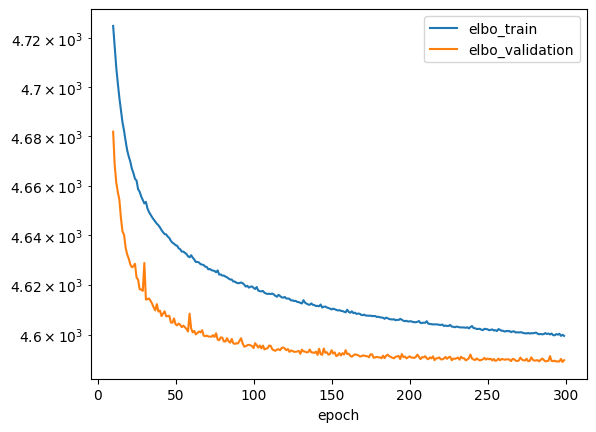

DE...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:58<00:00, 58.12s/it]
Ex


/tmp/ipykernel_2925/1065370654.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de["log10_pscore"] = np.log10(de["proba_not_de"])
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environmen

Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [1:15:00<00:00,  8.82s/it, v_num=1, train_loss_step=7.08e+3, train_loss_epoch=6.22e+3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [1:15:00<00:00,  9.00s/it, v_num=1, train_loss_step=7.08e+3, train_loss_epoch=6.22e+3]


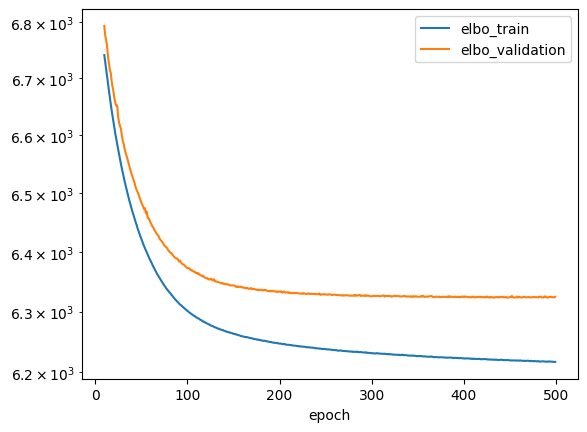

DE...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:53<00:00, 53.01s/it]
Oli


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [40:04<00:00,  4.82s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.37e+3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [40:04<00:00,  4.81s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.37e+3]


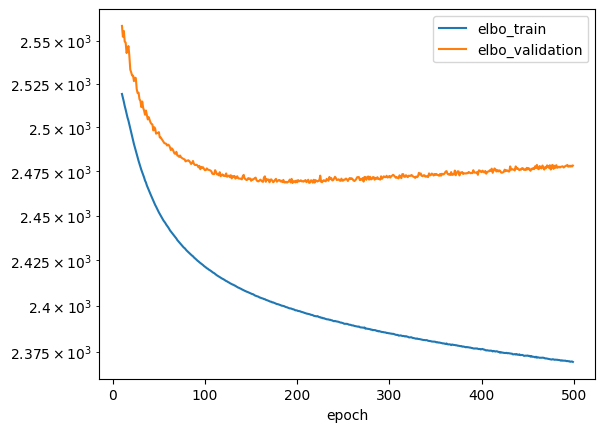

DE...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.15s/it]
In


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [20:23<00:00,  2.45s/it, v_num=1, train_loss_step=3.83e+3, train_loss_epoch=4.44e+3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [20:23<00:00,  2.45s/it, v_num=1, train_loss_step=3.83e+3, train_loss_epoch=4.44e+3]


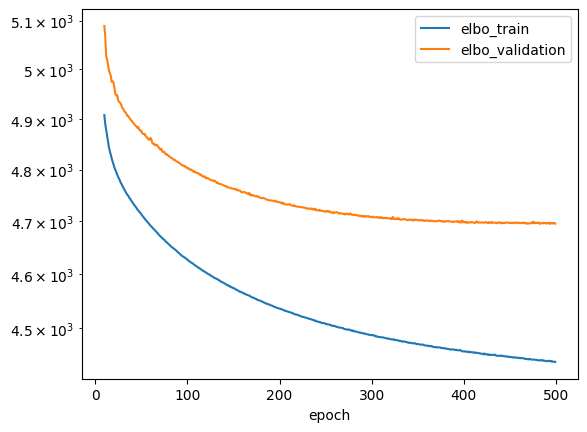

DE...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.83s/it]
Mic


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:00<00:00,  1.66it/s, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=1.88e+3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:00<00:00,  1.66it/s, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=1.88e+3]


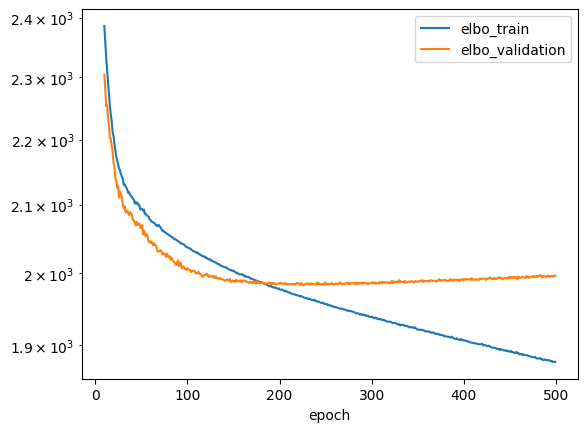

DE...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.05s/it]
Opc


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 500/500: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:55<00:00,  1.40it/s, v_num=1, train_loss_step=4.31e+3, train_loss_epoch=4e+3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:55<00:00,  1.41it/s, v_num=1, train_loss_step=4.31e+3, train_loss_epoch=4e+3]


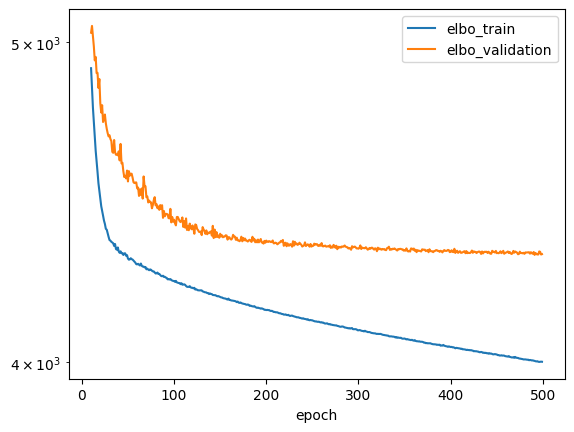

DE...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.99s/it]
Ast


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [08:20<00:00,  1.01s/it, v_num=1, train_loss_step=3.13e+3, train_loss_epoch=3.24e+3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [08:20<00:00,  1.00s/it, v_num=1, train_loss_step=3.13e+3, train_loss_epoch=3.24e+3]


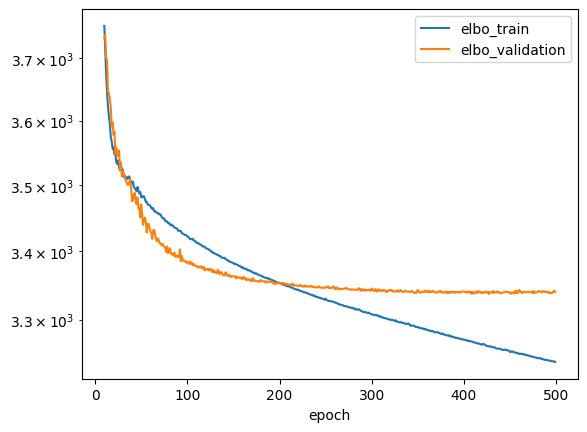

DE...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.66s/it]
Per


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/gpfs/home/ajoshi/.local/lib/python3.11/si

Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.03it/s, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.23e+3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.02it/s, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.23e+3]


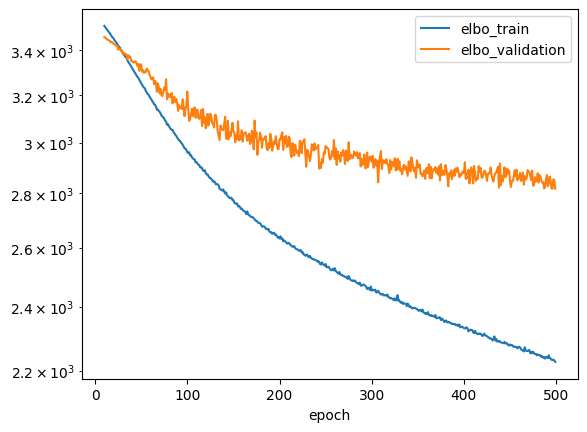

DE...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.58s/it]
End


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/gpfs/home/ajoshi/.local/lib/python3.11/si

Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.37it/s, v_num=1, train_loss_step=2.85e+3, train_loss_epoch=2.55e+3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s, v_num=1, train_loss_step=2.85e+3, train_loss_epoch=2.55e+3]


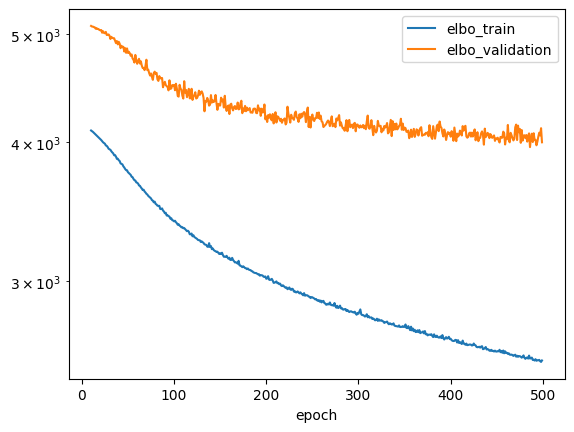

DE...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.58s/it]


In [40]:

##################################################Parameters:##################################
adata_ref_AD = filtered_mtx.copy()
results_dir = '../../results/ROSMAP/DE_genes/scvi/exp1_9Ctrls_16AD/'
###############################################################################################

#sc.pp.highly_variable_genes(
#    adata_ref_AD,
    #n_top_genes=6000,
#    subset=True
#)
scvi.model.SCVI.setup_anndata(adata_ref_AD, #layer="X",
                              categorical_covariate_keys=['sex']
                              #continuous_covariate_keys=["Age at Death"]
                             )
model = scvi.model.SCVI(
    adata_ref_AD, gene_likelihood="nb"
    )  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
model.train(
    check_val_every_n_epoch=1,
    max_epochs=300,
    early_stopping=True,
    early_stopping_patience=20,
    early_stopping_monitor="elbo_validation"
    )
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
plt.show()
de_change = model.differential_expression(idx1=adata_ref_AD.obs['condition']=='AD',
                                          idx2=adata_ref_AD.obs['condition']=='Ctrl', weights='uniform')
de = de_change.loc[de_change['is_de_fdr_0.05']==True,:]
de["log10_pscore"] = np.log10(de["proba_not_de"])
de.to_csv(results_dir+'var_genes_'+str(len(adata_ref_AD.var))+'_allcells.tsv',sep='\t')

for cell_type in pd.unique(adata_ref_AD.obs['broad.cell.type']):
    print(cell_type)
    cells = list(np.where(adata_ref_AD.obs['broad.cell.type']==cell_type)[0])
    adata_cell = adata_ref_AD[cells].copy()

    #sc.pp.highly_variable_genes(
        #adata_cell,
        #subset=True
        #)
    #print("Variable Genes:"+str(len(adata_cell.var)))
    scvi.model.SCVI.setup_anndata(adata_cell, #layer="X",
                                categorical_covariate_keys=['sex']
                                #continuous_covariate_keys=["Age at Death"]
                                )
    model = scvi.model.SCVI(
        adata_cell, gene_likelihood="nb")  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
    model.train(
        check_val_every_n_epoch=1,
        max_epochs=500,
        early_stopping=True,
        early_stopping_patience=500,
        early_stopping_monitor="elbo_validation",
        batch_size=53,
        plan_kwargs={"lr": 0.0001}
        )
    train_test_results = model.history["elbo_train"]
    train_test_results["elbo_validation"] = model.history["elbo_validation"]
    train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
    plt.show()
    de = model.differential_expression(idx1=adata_cell.obs['condition']=='AD',
                                       idx2=adata_cell.obs['condition']=='Ctrl', weights="uniform")
    de = de.loc[de['is_de_fdr_0.05']==True,:]
    de.loc[:,"log10_pscore"] = np.log10(de["proba_not_de"])
    cell_type = cell_type.replace('/','')
    cell_type = cell_type.replace(" ","")
    de.to_csv(results_dir+'var_genes_'+str(len(adata_cell.var))+'_'+cell_type+'.tsv',sep='\t')

